# Dirichlet Process GMM

In [1]:
import example_gmm
import example_dirichlet as dp
import torch

# Check that the same means and weights were used in the GMM example:
assert torch.equal(dp.true_means, example_gmm.data_means)
assert torch.equal(dp.true_weights, torch.ones((example_gmm.num_mixtures,)) / example_gmm.num_mixtures)

In [2]:
# Load generated data from file:
import pickle

from evaluation_icml2022 import *

experiments = {}
num_chains = 10
configs = [
    (L, alpha, K) for L in [20] for alpha in [1.0, 0.5] for K in [0, 1, 2]
]
for L, alpha, K in configs:
    key = toconfigstr(None, alpha, K)
    experiments[key] = []
    for i in range(num_chains):
        with open(f"lookahead_samples/dp_mixture_gmm_{i}__count150_eps0.05_L{L}_alpha{alpha}_K{K}.pickle", "rb") as f:
            experiments[key].append(pickle.load(f))

In [3]:
adjusted_experiments = adjust_for_iteration_time(experiments)

effort=defaultdict(<class 'list'>, {('npdhmc', ''): [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000], ('npladhmc', 'K=1'): [3960, 3820, 3880, 4020, 3800, 3900, 3780, 3940, 3900, 3940], ('npladhmc', 'K=2'): [4540, 4500, 4780, 4720, 4720, 4800, 4400, 4460, 4660, 4700], ('npdhmc-persistent', 'α=0.5'): [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000], ('npladhmc-persistent', 'α=0.5, K=1'): [3960, 4220, 4100, 3960, 4080, 4080, 3920, 4000, 4200, 4000], ('npladhmc-persistent', 'α=0.5, K=2'): [4560, 4660, 4380, 4520, 4520, 4800, 4420, 4520, 4900, 4480]})
reduction_factor={('npdhmc', ''): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ('npladhmc', 'K=1'): [1.32, 1.2733333333333334, 1.2933333333333332, 1.34, 1.2666666666666666, 1.3, 1.26, 1.3133333333333332, 1.3, 1.3133333333333332], ('npladhmc', 'K=2'): [1.5133333333333334, 1.5, 1.5933333333333333, 1.5733333333333333, 1.5733333333333333, 1.6, 1.4666666666666666, 1.4866666666666666, 1.5533333333333332, 1.566666666666

In [4]:
chains = {}
for config, runs in adjusted_experiments.items():
    print(f"{config}")
    thinned_runs = thin_runs(runs)
    chains.update(collect_chains(thinned_runs, config=config))
    print_running_time(runs, thinned_runs)


npdhmc: 1211.31s    0.8075s per sample (after thinning)
K=1
npladhmc: 1109.07s    0.9636s per sample (after thinning)
K=2
npladhmc: 1106.90s    1.1423s per sample (after thinning)
α=0.5
npdhmc-persistent: 1229.99s    0.8200s per sample (after thinning)
α=0.5, K=1
npladhmc-persistent: 1048.32s    0.9478s per sample (after thinning)
α=0.5, K=2
npladhmc-persistent: 1088.93s    1.1134s per sample (after thinning)


In [5]:
print("Acceptance ratios (lookahead statistics in parentheses):")
for config, runs in experiments.items():
    for method in runs[0].keys():
        stats = sum(torch.tensor(run[method]["stats"]) for run in runs)
        ratios = (stats.true_divide(torch.sum(stats))).tolist()
        accept_ratio = 1.0 - ratios[0]
        ratios_str = ", ".join(f"{r*100:.1f}%" for r in ratios[1:])
        print(f"{legend_str((method, config))}: {accept_ratio * 100:.1f}% ({ratios_str})")

Acceptance ratios (lookahead statistics in parentheses):
NP-DHMC: 69.7% (69.7%)
NP-Lookahead-DHMC (K=1): 78.3% (70.2%, 8.1%)
NP-Lookahead-DHMC (K=2): 80.4% (68.9%, 7.9%, 3.6%)
NP-DHMC pers. (α=0.5): 66.7% (66.7%)
NP-Lookahead-DHMC pers. (α=0.5, K=1): 74.0% (64.9%, 9.1%)
NP-Lookahead-DHMC pers. (α=0.5, K=2): 82.1% (69.4%, 8.7%, 4.0%)


In [6]:
import torch
import math

# log posterior predictive density
def dp_lppd(samples):
    M = len(samples)
    N = len(dp.test_data)
    #compute the probability density for each data point and sapmle (size M x N):
    log_ps = torch.stack([dp.loglikelihoods(torch.tensor(w), torch.tensor(m), dp.test_data) for w, m in samples])
    # average over all samples:
    logp_avg = torch.logsumexp(log_ps, dim=0) - math.log(float(M))
    # sum over all test data points:
    lppd = torch.sum(logp_avg)
    return lppd

def dp_lppd_stats(chains):
    lppds = torch.tensor([dp_lppd(chain) for chain in chains])
    std, mean = torch.std_mean(lppds)
    return f"{mean.item():.2f} +- {std.item():.2f} (standard deviation)"

print("Log posterior predictive densities:")
print(f"True:  {dp_lppd([(dp.true_weights.tolist(), dp.true_means.tolist())]):.2f}")
for method in chains.keys():
    print(f"{legend_str(method)}:  {dp_lppd_stats(chains[method])}")

Log posterior predictive densities:
True:  -674.81
NP-DHMC:  -676.11 +- 0.43 (standard deviation)
NP-Lookahead-DHMC (K=1):  -676.14 +- 0.57 (standard deviation)
NP-Lookahead-DHMC (K=2):  -676.19 +- 0.75 (standard deviation)
NP-DHMC pers. (α=0.5):  -676.13 +- 0.87 (standard deviation)
NP-Lookahead-DHMC pers. (α=0.5, K=1):  -675.94 +- 1.23 (standard deviation)
NP-Lookahead-DHMC pers. (α=0.5, K=2):  -675.59 +- 0.80 (standard deviation)


In [7]:
# graph LPPD progression:
from tqdm import tqdm
lppd_data = []
num_samples = max(len(c) for cs in chains.values() for c in cs)
resolution = 20
# start = 1
start = 2
for i in tqdm(range(start, resolution + 1)):
    for method in chains.keys():
        num_chains = len(chains[method])
        min_chain_length = min(len(c) for c in chains[method])
        n = i * num_samples // resolution
        if n <= min_chain_length:
            truncated_lppds = [dp_lppd(chain[:n]).item() for chain in chains[method]]
        else:
            truncated_lppds = [None for _ in chains[method]]
        lppd_data += [(legend_str(method), n, lppd) for lppd in truncated_lppds]
    ground_truth = dp_lppd([(dp.true_weights.tolist(), dp.true_means.tolist())]).item()
    lppd_data.append(("ground truth", n, ground_truth))

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


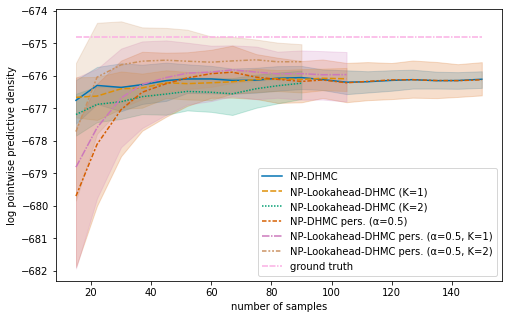

In [8]:
# graph LPPD progression:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

df = pandas.DataFrame([lppd for lppd in lppd_data if lppd[0] not in ["IS (L=20)", "IS (L=4)"]], columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(8,5))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
)
plt.legend(loc="lower right")
plt.show()
plot.get_figure().savefig("icml2022-dpmm-lppd-plot.pdf", bbox_inches="tight")